## Activations(forward pass), Gradients(backward pass), Batchnorm

2024.07.31

语言模型在transformer前的中流砥柱，RNN和他的变体GRU、LSTM

为什么在介绍RNN之前需要介绍模型训练中的activation和gradient,这对于理解RNN系列网络发展历史很有帮助。虽然RNN网络的表示能力非常强(very expressive, they are universal approximator and can in priciple inplement all the algorithms)，但是这一类网络使用一阶导数梯度下降很难优化,理解这一点的核心就是理解训练中的activations,gradients,后面的网络都是来解决这一类问题


### 1.original code

In [184]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn

In [11]:
# read in all the words
words = open('makemore/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [13]:
len(words)
# number of examples

32033

In [24]:
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '.': 0}

In [25]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [26]:
# build the database
block_size= 3 # context_window, 4 gram
def build_dataset(words):
    X, Y  = [], []
    for w in words:
        context = [0] * block_size # extend [0] -> [0,0,0]
        for ch in w +'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # concat two list 
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
print(f"training shape : {Xtr.shape},{Ytr.shape}") # 0.8 training
print(f"Dev shape : {Xdev.shape},{Ydev.shape}") # 0.1 validation 
print(f"Test shape : {Xte.shape},{Yte.shape}") # 0.1 test
print(vocab_size)

training shape : torch.Size([182441, 3]),torch.Size([182441])
Dev shape : torch.Size([22902, 3]),torch.Size([22902])
Test shape : torch.Size([22803, 3]),torch.Size([22803])
27


In [28]:
# MLP revisted
n_embd = 10 # one-hot to embedding
n_hidden = 200
g = torch.Generator().manual_seed(2147483467)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,   generator=g)
b1 = torch.randn(n_hidden,                      generator=g)
W2 = torch.randn(n_hidden,vocab_size,           generator=g)
b2 = torch.randn(vocab_size,                    generator=g)

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [30]:
Xtr.shape[0]

182441

In [34]:
# 过去的数据我们是怎么做的？
# 1.每一个dataset切分为不同的batch,这样整体的batch基本确保每个epoch可以把dataset过一遍; 数据训练更加有效
# 2.有了dataset划分为基本的datasample, 这样其实就没有epoch这个概念，只用iteration这个概念，每次从dataset随机sample一个batch_size的数据，这样的优势是什么?

# 3.注意一个点：(2)表示数字2， (2,)才表示一个tuple, 因此torch.randint(0,Xtr.shape[0],(batch_size))会报错，而torch.randint(0,Xtr.shape[0],(batch_size,)不会报错
# same optimization
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g) #每次batch的sample数据其实是index
    Xb,Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb] #[batch,block_size,n_emb]
    embcat = emb.reshape(emb.shape[0],-1) # [batch, block_size * n_emb]
    hpreact = embcat @ W1 + b1
    h1 = torch.tanh(hpreact)
    logits = h1 @ W2 + b2
    
    # loss computation
    loss = F.cross_entropy(logits,Yb) # [batch, vocab],[vocab]
    
    # zero_grad
    for p in parameters:
        p.grad = None
    
    # backward
    loss.backward()

    # optimization
    lr = 0.1 if i < 100000 else 0.1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i :7d} / {max_steps : 7d}: {loss.item() :.4f}")
    lossi.append(loss.log10().item())
    

      0 /  200000: 25.8893
  10000 /  200000: 1.7689
  20000 /  200000: 2.5928
  30000 /  200000: 2.2552
  40000 /  200000: 1.9236
  50000 /  200000: 2.5633
  60000 /  200000: 2.3320
  70000 /  200000: 2.8833
  80000 /  200000: 2.2424
  90000 /  200000: 2.1624
 100000 /  200000: 1.9963
 110000 /  200000: 2.2741
 120000 /  200000: 2.3269
 130000 /  200000: 2.5116
 140000 /  200000: 2.2918
 150000 /  200000: 2.0778
 160000 /  200000: 2.2967
 170000 /  200000: 2.4276
 180000 /  200000: 2.3654
 190000 /  200000: 2.2814


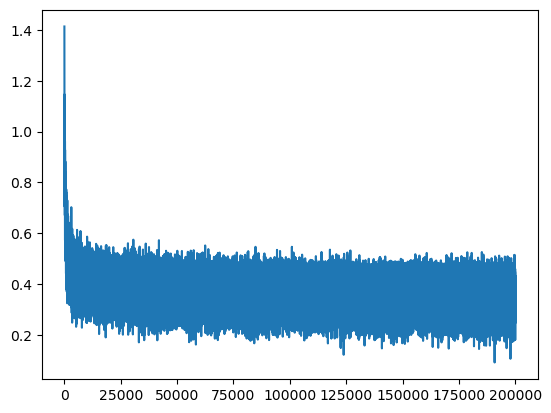

In [37]:
plt.plot(lossi)

In [38]:
@torch.no_grad() # 函数的装饰器，表示调用这个函数的时候不用建立计算图，等价于with torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x] #[N,3,emb]
    embcat = emb.reshape(emb.shape[0],-1) #[N,3*emmb]
    h = torch.tanh(embcat@W1+b1) # [N,n_hidden]
    logits = h@W2+b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('test')


train 2.2018580436706543
test 2.262258768081665


In [46]:
# sample from the model
# batch_zie = 1,从logtis中sample, 需要不断调整context_window,
g = torch.Generator().manual_seed(7777777)

for _ in range(20):
    out = []
    context = [0] *block_size #[context window] #[block_size]
    while True:
        emb = C[torch.tensor(context)] # [block_size,emb]
        embcat = emb.reshape(1,-1) # [1,block_size*emb]
        h = torch.tanh(embcat @ W1 + b1) # [1,hidden]
        logits = h @ W2 + b2 # [vocab]
        probs = F.softmax(logits,dim=-1) # [1,vocab]-prob
        # sample from distribution
        ix = torch.multinomial(probs,1,replacement=True).item()  # [1]
        # shift the context window and track the sample
        context = context[1:] + [ix]
        # if we sample the special '.' token, break
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)[:-1])


laileer
fita
kaith
ah
doristyn
anna
yideli
yell
ari
maraze
elle
geaenuiston
myonnei
grayleni
mari
youldemontaon
yani
ramoni
gin
macie


### 2. 最开始的Loss太高了，是因为initialization非常不好

初始化好的作用：
1. loss在刚开始训练的时候是我们理想的loss----loss刚开始更低，和uniform distribution接近
2. loss曲线并不会像一个hocky stick,因为我们拿走了网络中最简单的那一个部分,
3. 最终训练集和测试集的loss比random initialization loss更低,因为我们花了更多的cycle去真正优化模型，而不是让模型在前几个iterations只是去squashing down the weights ---- 现在weight刚开始更低，在零附近

总之，初始化好了之后，可以让模型花更多时间有效的学习，而不是浪费前面的iteration在squashing down weights上

In [48]:
# 刚开始的loss是27，非常差
# 理论上初始化之后希望得到一个uniform distribution, 概率为1/27
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
# at initialization, the nueral net is creating probability distributions that are all messed up.神经网络在初始化概率分布是乱七八糟的
# some characters are very confident and some are not confident
# basically what's happening is that the network is very confidently wrong,这也就导致了刚开始的loss非常高

In [70]:
# 测试一下4-dimensional example of the issue
logits = torch.randn(4) * 20 # confidently wrong
probs = torch.softmax(logits,dim=-1)
loss = -probs[2].log()
logits,probs,loss

(tensor([-26.7321,   7.8644,  -8.7521,  16.5426]),
 tensor([1.6068e-19, 1.7023e-04, 1.0341e-11, 9.9983e-01]),
 tensor(25.2949))

In [72]:
# 核心的目的是当网络初始化的时候，我们希望logits都在zero附近，这样得到uniform distribution方便优化
# PS: 其实将logits固定为某一个正数或者某一个负数也可以，但是为了对称性，我们希望我们的logits都是0
logits = torch.tensor([0.,0.,0.,0.])
probs = torch.softmax(logits,dim=-1)
loss = -probs[2].log()
logits,probs,loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [104]:
# 重新看我们的初始化和代码------核心目标，希望logits最后在零附近,不要变成extreme value
# 1.为什么大部分模型的projection layer, bias都为False
# MLP revisted
n_embd = 10 # one-hot to embedding
n_hidden = 200
g = torch.Generator().manual_seed(2147483467)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,   generator=g)
b1 = torch.randn(n_hidden,                      generator=g) 
W2 = torch.randn(n_hidden,vocab_size,           generator=g) * 0.01 # logits = h @ W2, 因此希望logits在零附近，可以给W2一个很小的值,但是最好不要给W2完全=0，虽然这样会得到一个最好的initialization loss
b2 = torch.randn(vocab_size,                    generator=g) * 0 # b2直接设置为0，因为希望b2附近的bias为0,NeMO项目中初始化projection b2也为0

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [105]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g) #每次batch的sample数据其实是index
    Xb,Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb] #[batch,block_size,n_emb]
    embcat = emb.reshape(emb.shape[0],-1) # [batch, block_size * n_emb]
    hpreact = embcat @ W1 + b1
    h1 = torch.tanh(hpreact)
    logits = h1 @ W2 + b2
    
    # loss computation
    loss = F.cross_entropy(logits,Yb) # [batch, vocab],[vocab]
    
    # zero_grad
    for p in parameters:
        p.grad = None
    
    # backward
    loss.backward()

    # optimization
    lr = 0.1 if i < 100000 else 0.1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i :7d} / {max_steps : 7d}: {loss.item() :.4f}")
    lossi.append(loss.log10().item())

    # ---DEBUG---
    # break
    

      0 /  200000: 3.3350
  10000 /  200000: 1.8129
  20000 /  200000: 2.2563
  30000 /  200000: 2.0792
  40000 /  200000: 1.8910
  50000 /  200000: 2.2265
  60000 /  200000: 2.2619
  70000 /  200000: 2.3287
  80000 /  200000: 2.3423
  90000 /  200000: 1.8591
 100000 /  200000: 1.8025
 110000 /  200000: 2.1844
 120000 /  200000: 2.1090
 130000 /  200000: 2.0773
 140000 /  200000: 2.1402
 150000 /  200000: 1.9608
 160000 /  200000: 1.9829
 170000 /  200000: 2.3272
 180000 /  200000: 2.3824
 190000 /  200000: 2.1729


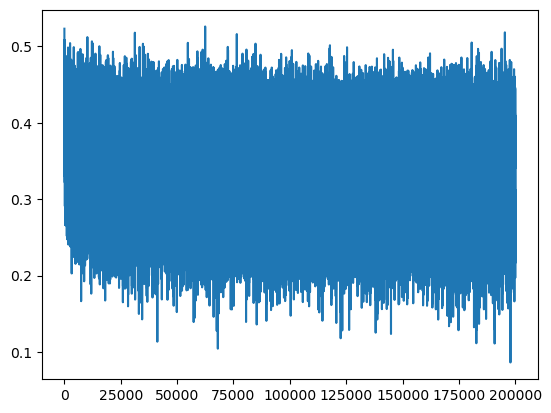

In [106]:
plt.plot(lossi)
# by andrej:
# the plot of loss doesn't have this hocky shape appearance , because what's happening in the hocky stick, the ver
# first iterations of the loss what's happening during the optimization is the optimization is just squashing down the logits
# and then it's rearranging the logits. So basically we took away this easy part of the loss function, the weights were just being shrunk down.
# so therefore we don't get these easy gians at the beginning, and we're just getting some of the hard gains of training the neural nets

In [103]:
logits[0]

tensor([-0.1998, -0.0653, -0.0585,  0.0231, -0.1083,  0.0320,  0.0511,  0.1527,
         0.0324,  0.0747,  0.0370, -0.1811, -0.3098,  0.1957,  0.2041, -0.2903,
         0.2246,  0.0566,  0.0523, -0.2549, -0.0042,  0.0157, -0.0253, -0.0394,
        -0.1591,  0.0090,  0.0607], grad_fn=<SelectBackward0>)

In [98]:
# 注意标准初始化的结果和W2=0,b=0结果一样，但是这样初始化并不好!!!Andrej : I'm very nervous
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [107]:
@torch.no_grad() # 函数的装饰器，表示调用这个函数的时候不用建立计算图，等价于with torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x] #[N,3,emb]
    embcat = emb.reshape(emb.shape[0],-1) #[N,3*emmb]
    h = torch.tanh(embcat@W1+b1) # [N,n_hidden]
    logits = h@W2+b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('test')


train 2.1460914611816406
test 2.2219550609588623


### 3. saturated activation function tanh 

In [144]:
# 重新看我们的初始化和代码------核心目标，希望logits最后在零附近,不要变成extreme value
# 1.为什么大部分模型的projection layer, bias都为False
# MLP revisted
n_embd = 10 # one-hot to embedding
n_hidden = 200
g = torch.Generator().manual_seed(2147483467)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,   generator=g) * 0.2 # 设置的稍微大一些，可能会有一点多样性，但是核心还是还能让hpreact在0附近
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn(n_hidden,vocab_size,           generator=g) * 0.01 # logits = h @ W2, 因此希望logits在零附近，可以给W2一个很小的值,但是最好不要给W2完全=0，虽然这样会得到一个最好的initialization loss
b2 = torch.randn(vocab_size,                    generator=g) * 0 # b2直接设置为0，因为希望b2附近的bias为0,NeMO项目中初始化projection b2也为0

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [145]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g) #每次batch的sample数据其实是index
    Xb,Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb] #[batch,block_size,n_emb]
    embcat = emb.reshape(emb.shape[0],-1) # [batch, block_size * n_emb]
    hpreact = embcat @ W1 + b1 
    h = torch.tanh(hpreact) # h很多在1,-1之间，因此需要将hpreact变成离零很近的数值
    logits = h @ W2 + b2
    
    # loss computation
    loss = F.cross_entropy(logits,Yb) # [batch, vocab],[vocab]
    
    # zero_grad
    for p in parameters:
        p.grad = None
    
    # backward
    loss.backward()

    # optimization
    lr = 0.1 if i < 100000 else 0.1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i :7d} / {max_steps : 7d}: {loss.item() :.4f}")
    lossi.append(loss.log10().item())

    # ---DEBUG---
    # break
    

      0 /  200000: 3.3204
  10000 /  200000: 1.8148
  20000 /  200000: 2.1838
  30000 /  200000: 2.0050
  40000 /  200000: 1.8666
  50000 /  200000: 2.2007
  60000 /  200000: 2.0951
  70000 /  200000: 2.5550
  80000 /  200000: 2.3031
  90000 /  200000: 1.8860
 100000 /  200000: 1.7799
 110000 /  200000: 2.2700
 120000 /  200000: 2.0954
 130000 /  200000: 1.9765
 140000 /  200000: 2.1081
 150000 /  200000: 1.9246
 160000 /  200000: 1.9466
 170000 /  200000: 2.0160
 180000 /  200000: 2.3037
 190000 /  200000: 2.1909


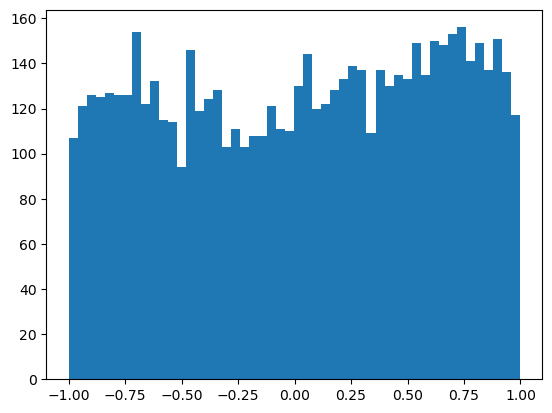

In [139]:
plt.hist(h.view(-1).tolist(),50); # a semicolon to suppress a bunch of output we don't want

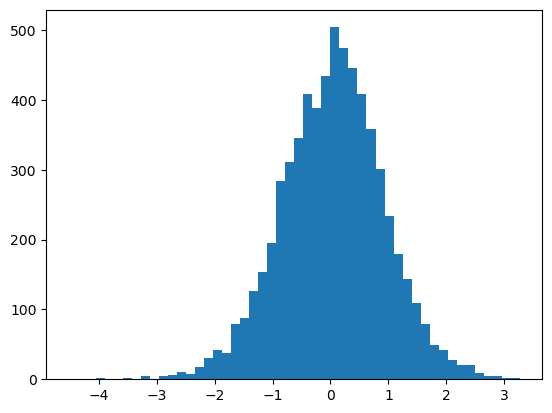

In [140]:
plt.hist(hpreact.view(-1).tolist(),50); # 激活函数前的值非常大，从-15到15，所以这些value都被squashing到-1和1

In [125]:
# def tanh(self):
#     # auto grad engine不在乎每个步骤是不是基础运算，只要定义出the derivative of the partent node with repsect to the child node即可---定义local grad
#     x = self.data
#     t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
#     out = Value(t,(self,), 'tanh')    
#     def _backward():
#         self.grad += (1 - t**2) * out.grad # chain rule : local gradient * global gradient
#     out._backward = _backward
#     return out

# 每一个value,如果tanh之后t非常接近-1或者1，那么1-t**2就是0，所以tanh就会kill掉所有global gradient,也就是local gradient为0，阻止了global gradient

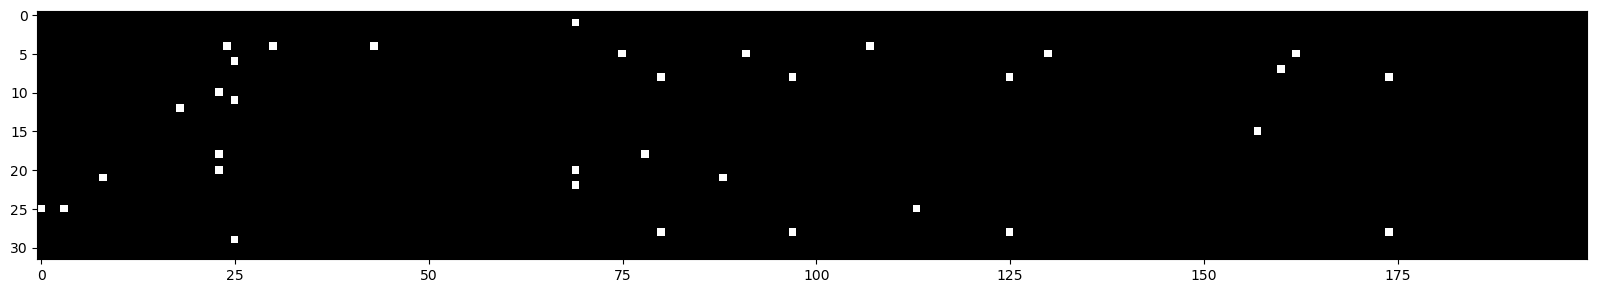

In [141]:
# 看一下h通过tanh之后有多少是大于0.99的
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest') # [32, 200] input, 200 neurons, white for True and black for False
# 大部分白色的区域，梯度会被destroyed
# 200个neuron, 当某一列全白色，表示这一个batch的所有梯度过来，都不会更新这一个neuron,表示dead tensor
# 不管什么input进来，这一个nueron是-1或者1，无法更新---- tanh dead neuron
# 不管什么input进来，这个neuron都是负数，这个relu neuron是一个dead neuron , 这个neuron的weights and bias都不会再被更新,在初始化和训练都有可能发生,训练中如果梯度太大，lr也太大，从此之后没有example可以activate这些neuron
# relu dead neuron it's like a permanent brain damage in a mind
# leaky ReLU没有flat tail,永远会有梯度

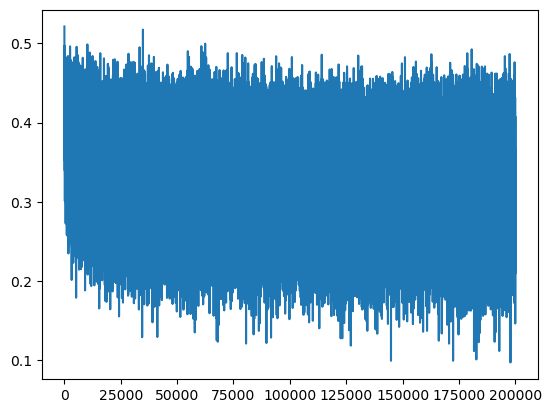

In [147]:
plt.plot(lossi)

In [146]:
@torch.no_grad() # 函数的装饰器，表示调用这个函数的时候不用建立计算图，等价于with torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x] #[N,3,emb]
    embcat = emb.reshape(emb.shape[0],-1) #[N,3*emmb]
    h = torch.tanh(embcat@W1+b1) # [N,n_hidden]
    logits = h@W2+b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('test')


train 2.10556960105896
test 2.181131601333618


In [ ]:
# loss log

# original:
train 2.2018580436706543
test 2.262258768081665

# fix softmax confidently wrong - fix projection layer initialization
train 2.1460914611816406
test 2.2219550609588623

# fix tanh layer too saturated at init - fix preactivation layer saturation 
train 2.10556960105896
test 2.181131601333618

### 4.Kaming init

当我的网络有很多很多层，每一层该怎么正确的初始化，该怎么控制W1 = W1 * 0.2这种参数？


tensor(0.0002) tensor(1.0040)
tensor(-0.0010) tensor(1.0193)
tensor(0.0415) tensor(1.4046)


Text(0.5, 1.0, 'Y_B')

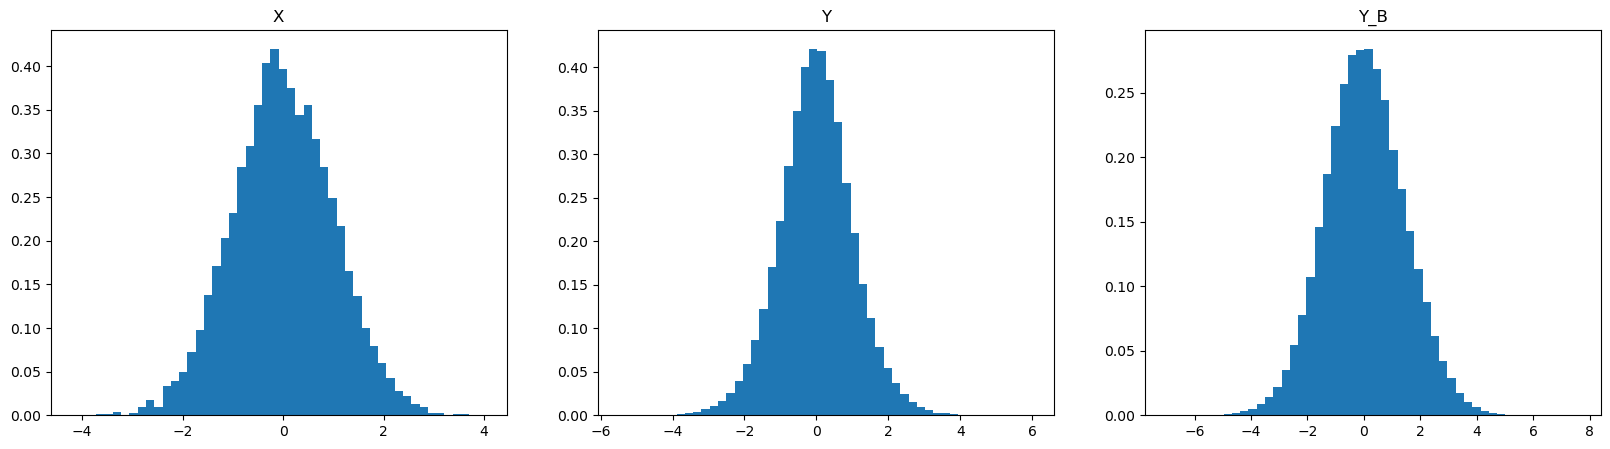

In [173]:
import math
# 很重要的一点，两个randn矩阵相乘，均值不变，但是std会变大非常多
x = torch.randn(1000,10)# random sample gaussian sample
w = torch.randn(10,200) / 10**0.5 # variance = 10 * (10**0.5)^2
b = torch.randn(200)
y = x @ w # [1000,200]
y_b = y + b
print(x.mean(),x.std())
print(y.mean(),y.std())
print(y_b.mean(),y_b.std())
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.title(f"X")
plt.subplot(132)
plt.hist(y.view(-1).tolist(),50,density=True);
plt.title(f"Y")
plt.subplot(133)
plt.hist(y_b.view(-1).tolist(),50,density=True);
plt.title(f"Y_B")

数学上如何解释这种现象？

背景:x,y是两个独立的随机变量基本公式如下
- $E[x] =\int p(x)dx,E[f(x)]=\int f(x)p(x)dx$
- $D[x] =E[x^2]-(E[x])^2 $
- $E[x+y] = E[x] + E[y]$ 如果x,y彼此独立
- $E[xy] = E[x]E[y]$
- $D(x+y) = D[x] + D[y]$
- $D[xy] == E[(xy)^2] - (E[xy])^2 = E[x^2 y^2] - (E[x]E[y])^2= E[x^2]E[y^2]-0=1$

form : $x_i \in N(0,1), y_i \in N(0,1)$

z = x @ y = $\sum\limits_{i=1}^N x_iy_i$ 代表矩阵相乘的每一个元素是由一组向量内积得到

$E[z] = \sum\limits_{i=1}^N E[x_iy_i]= \sum\limits_{i=1}^N E[x_i]E[y_i]=0$   
$D[z] = \sum\limits_{i=1}^N D[x_iy_i]= N$, N=10表示两个向量内积的个数 
$Var(z)=\sqrt{D[z]}=\sqrt{10}\approx3.1623$

PS : 1. a,b b,c 一共有 $a\times b\times c= 2abc$ 个浮点数操作

PS : 2. 同理w+b之后，也会使得variance进一步增大

PS : 3. 假设全是FNN,一层之后activation为$\mathcal{N}(0,N)$,两层之后为$\mathcal{N}(0,N^2)$, N为hidden layer的大小

总结: $Var[y] = nVar[w]Var[x]$

****

from : Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification

Kaming initialization

假设神经网络是一系列的MLP:$W,\bold{b}$ +激活函数$f$

$\bold{y}_L=\bold{W}_l\bold{x}_l+\bold{b}_l,\bold{x}_l=f(\bold{y}_{l-1}),\forall l \in [2,L]$ 

$\bold{y}_1=\bold{W}_1\bold{x}_1+\bold{b}_1$

考虑以下假设：  
1. $\bold{b}=0$, $\bold{W}_l$的每一个元素都是iid的,$x_l$的每一个元素都是iid的，$x_l$和$W_l$的每一个元素都是独立的   

2. $w_l$来自一个均值为0,方差为某个数的高斯分布 (symmetric distribution)   

3. $y_l$的均值在0附近，是一个对称的分布

考虑每一个元素$y_l,x_l,w_l$都是$\bold{y}_l,\bold{x}_l,\bold{W}_l$中的任意一个随机变量：

现在我们希望使得输出$y_l$的方差始终控制在一个常数，如0，对$w_l$可能的分布进行探索，主要希望控制$w_l$的初始化方差$Var[w_l]$


$Var[y_{l,i}]=\sum\limits_{k=1}^{n_l} x_{l,k}W_{l,(i,k)}$,考虑到W和x中的元素相互独立，因此可以通过方差分解      

$Var[y_l]=n_lVar[w_lx_l]=n_l(E[w_l^2x_l^2]-E[w_lx_l]^2)$,考虑到$E[w_l]=0$,则$Var[y_l]=n_lE[w_l^2x_l^2]=n_lE[w_l^2]E[x_l^2]$

考虑到对于任意随机变量$E[x^2]=D[x]-(E[x])^2$,则$E[w_l^2]=Var[w_l]$

$Var[y_l]=n_lVar[w_l]E[x_l^2]$

注意到$E[x_l^2]在多数情况不为0，特别是对于ReLU, x_l=\max(0,y_{l-1}), E[x_l]=\frac{1}{2}Var[y_{l-1}]$对于$y_{l-1}$为任意概率分布。而有无激活函数、不同激活函数会导致$E[x_l^2]$的不同，

proof : $E[x_l^2]=E[g(y)]=\int\limits_{-\infty}^{\infty}max(0,y_{l-1})^2p(y_{l-1})dy_{l-1}$其中g(y)=max(0,y_{l-1})^2

proof :$E[x_l^2]=\int\limits_{0}^{\infty}y_{l-1}^2p(y_{l-1})dy_{l-1}$只考虑$y_{l-1}>0$的部分,且p(y)与$y_2$都是对称，因此有:

proof :$E[x_l^2]=\frac{1}{2}\int\limits_{-\infty}^{\infty}y_{l-1}^2p(y_{l-1})dy_{l-1}= \frac{1}{2}E[y_{l-1}^2]=\frac{1}{2}Var[y_{l-1}]$,由于$E[y_{l-1}]=0$

因此$Var[y_l]=\frac{1}{2}n_lVar[w_l]Var[y_{l-1}]$

- 如果无激活函数，可以看作$x_l=y_{l-1},E[x_l]=E[y_{l-1}]=0,Var[y_{l-1}]=Var[x_l]=E[x_l^2]$, $Var[y_l]=n_lVar[w_l]Var[y_{l-1}]$

$n_l$前面的系数称为gain,是不同激活函数的期望带来的结果

如果有L层放在一起,这样导致复杂度通过$n_l$指数增加

$Var[y_L]=Var[y_1](\Pi_{l=2}^L \frac{1}{2}n_lVar[w_l])$  

这样如果想要每一层$\frac{1}{2}n_lVar[w_l]=1;Var[w_l]=\frac{2}{n_l}$,

对于第一层相当于没有ReLU函数，因此$n_1Var[w_1]=1$，但是$Var[w_1]=\frac{2}{n_1}$简化了代码

同时作者发现，当使用这种初始化方式初始化forward propagation的时候，backward梯度同样也近似正确的初始化



-----


Same idea also in transformer, attention score = $\frac{QK^T}{\sqrt{d_k}}$, as $qk^T$ has mean 0 and vadiance d_k

In [188]:
x = nn.Linear(10,10)

In [189]:
x.bias

Parameter containing:
tensor([-0.1754,  0.1014, -0.1699, -0.0982,  0.1684,  0.2071,  0.2008,  0.0628,
        -0.2355, -0.0386], requires_grad=True)

In [182]:
# FFN在参数全是均匀高斯分布的情况下，会explore
x = torch.randn(10000,16)# random sample gaussian sample
w1 = torch.randn(16,16) 
w2 = torch.randn(16,16)
w3 = torch.randn(16,16)
y1 = x @ w1
y2 = y1 @ w2
y3 = y2 @ w3
print(x.mean(),x.var())
print(y1.mean(),y1.var())
print(y2.mean(),y2.var())
print(y3.mean(),y3.var()) # 可以明显的看到参数variance会explode

tensor(0.0025) tensor(1.0019)
tensor(-0.0025) tensor(15.1803)
tensor(0.0199) tensor(199.1286)
tensor(0.0840) tensor(3066.2524)


In [158]:
# 深度学习都是一些矩阵操作block,如何设置初始化使得activation value都是合理的

# andrej，现在有很多种方法使得训练非常稳定，所以一个非常精确的初始化似乎不那么重要，大致上只需要除以根号下n就可以
# 1. residue connections, 
# 2. normalizations
# 3. 更好的optimizer

tensor(3.1623)

In [191]:
(torch.randn(10000) * 0.2 ).std() # torch.randn()*的值表示控制std,比如NeMO项目中控制噪音的标准差

tensor(0.1970)

In [192]:
# tanh进行初始化的时候，gain=5/3, 
(5/3) / (30**0.5)

0.3042903097250923

In [193]:
# 重新看我们的初始化和代码------核心目标，希望logits最后在零附近,不要变成extreme value
# 1.为什么大部分模型的projection layer, bias都为False
# MLP revisted
n_embd = 10 # one-hot to embedding
n_hidden = 200
g = torch.Generator().manual_seed(2147483467)
C = torch.randn(vocab_size, n_embd,             generator=g)
W1 = torch.randn(n_embd*block_size, n_hidden,   generator=g) * (5/3)*(n_embd*block_size)**0.5 # kaming init
b1 = torch.randn(n_hidden,                      generator=g) * 0.01
W2 = torch.randn(n_hidden,vocab_size,           generator=g) * 0.01 # logits = h @ W2, 因此希望logits在零附近，可以给W2一个很小的值,但是最好不要给W2完全=0，虽然这样会得到一个最好的initialization loss
b2 = torch.randn(vocab_size,                    generator=g) * 0 # b2直接设置为0，因为希望b2附近的bias为0,NeMO项目中初始化projection b2也为0

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


通过kaming initial，我们初始化的时候不需要猜一个标准差数值，而是有一些semi-principled方法来确定每一层初始化的方差大致应该是多少，特别是那些对应不同激活函数的weight

### 5.Batch normalization

正是因为有了这些normalization,才使得现代训练神经网络非常可靠